In [1]:
from visualizer import get_local
get_local.activate()

import os
ROOT_PATH="/data/aofei"
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
os.environ["TRANSFORMERS_CACHE"] = f"{ROOT_PATH}/huggingface_cache/transformers"
os.environ["HF_HOME"] = f"{ROOT_PATH}/huggingface_cache/transformers"

from PIL import Image
import seaborn as sns
import torch
import torch.nn.functional as F
import json
import copy
import numpy as np

import sys
sys.path.append("/home/avc6555/research/MedH/Mitigation/LVLMs/llava-med")

from llava import LlavaLlamaForCausalLM
from llava.conversation import conv_templates
from llava.utils import disable_torch_init
from transformers import CLIPVisionModel, CLIPImageProcessor, StoppingCriteria
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig

from PIL import Image
import random
import math

from utils import show_image_relevance

/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/hub.py:123: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytr

In [2]:
# load model
ROOT_PATH="/data/aofei"
model_name = f"{ROOT_PATH}/LLM/llava_med"
# lora weights
# dir="llava_med/lora/epoch6"
# dataset="Slake"
# peft_path = f"{ROOT_PATH}/hallucination/mitigation/{dataset}/{dir}/checkpoints"

DEFAULT_IMAGE_TOKEN = "<image>"
DEFAULT_IMAGE_PATCH_TOKEN = "<im_patch>"
DEFAULT_IM_START_TOKEN = "<im_start>"
DEFAULT_IM_END_TOKEN = "<im_end>"

model_name = os.path.expanduser(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = LlavaLlamaForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, use_cache=True).cuda()
# print("vision tower", model.config.mm_vision_tower)
image_processor = CLIPImageProcessor.from_pretrained(model.config.mm_vision_tower, torch_dtype=torch.float16)
vision_tower = model.model.vision_tower[0]
vision_tower.to(device='cuda', dtype=torch.float16)

mm_use_im_start_end = getattr(model.config, "mm_use_im_start_end", False)
tokenizer.add_tokens([DEFAULT_IMAGE_PATCH_TOKEN], special_tokens=True)
if mm_use_im_start_end:
    tokenizer.add_tokens([DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN], special_tokens=True)

vision_config = vision_tower.config
vision_config.im_patch_token = tokenizer.convert_tokens_to_ids([DEFAULT_IMAGE_PATCH_TOKEN])[0]
vision_config.use_im_start_end = mm_use_im_start_end
if mm_use_im_start_end:
    vision_config.im_start_token, vision_config.im_end_token = tokenizer.convert_tokens_to_ids([DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN])
image_token_len = (vision_config.image_size // vision_config.patch_size) ** 2
print(image_token_len, "token length")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/data/aofei/conda/env/medh/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

256 token length


In [3]:
import clip
_, preprocess = clip.load("ViT-B/32", device='cpu', jit=False)

class KeywordsStoppingCriteria(StoppingCriteria):
    def __init__(self, keywords, tokenizer, input_ids):
        self.keywords = keywords
        self.tokenizer = tokenizer
        self.start_len = None
        self.input_ids = input_ids
        

    def __call__(self, output_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        if self.start_len is None:
            self.start_len = self.input_ids.shape[1]
        else:
            outputs = self.tokenizer.batch_decode(output_ids[:, self.start_len:], skip_special_tokens=True)[0]
            for keyword in self.keywords:
                if keyword in outputs:
                    return True
        return False

In [4]:
def get_attention_weights_example(model, question, image_path, conv_mode="simple"):
    qs = question.replace(DEFAULT_IMAGE_TOKEN, '').strip()
    
    image = Image.open(image_path)
    image_tensor = image_processor.preprocess(image, return_tensors='pt')['pixel_values'][0]
    images = image_tensor.unsqueeze(0).half().cuda()
    if getattr(model.config, 'mm_use_im_start_end', False):
        qs = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_PATCH_TOKEN * image_token_len + DEFAULT_IM_END_TOKEN + '\n' +  qs
    else:
        qs = DEFAULT_IMAGE_PATCH_TOKEN * image_token_len + '\n' + qs
    cur_prompt = '<image>' + '\n' +  qs

    conv = conv_templates[conv_mode].copy()
    conv.messages = []
    conv.append_message(conv.roles[0], qs)
    prompt = conv.get_prompt()
    inputs = tokenizer([prompt])

    input_ids = torch.as_tensor(inputs.input_ids).cuda()



    keywords = ['###']
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)
    

    with torch.inference_mode():
        outputs = model.generate(
            input_ids,
            images=images,
            do_sample=False,
            temperature=0.7,
            max_new_tokens=1024,
            output_attentions=True,
            return_dict_in_generate=True,
            stopping_criteria=[stopping_criteria])

    text = tokenizer.decode(outputs["sequences"][0]).strip()
    cache = get_local.cache
    print(text.split("###")[-2])
    return cache, text, outputs, input_ids, image

In [5]:
#LOAD LORA
from llava.model.moe_llava import LoRA_MOE_FFN, LoRA_MOE_QK, LoRA_MOE_QK_old
# dir="llava_med/moe_img_query/abd_04/lora_0.15_bbox_0.1/epoch6"
dir="llava_med/ours_v1/top128_balance/all_expert_8_16_rank16/lora_0_bbox_0.1/epoch6_seed4"
# dir="llava_med/moe_img_query/lora_0.15_bbox_0.1/epoch6"

# dir="llava_med/visual_enhance/lora_0.03_bbox_0.01/epoch6"
# dir="llava_med/visual_enhance/abd/lora_0.15_bbox_0.02/epoch6"
dataset="Slake"
# dir="llava_med/lora/epoch6_bbox"
# dataset="VQA_RAD"
peft_path = f"{ROOT_PATH}/hallucination/mitigation/{dataset}/{dir}/checkpoints"

# if peft_path is not None and len(str(peft_path))>4:
#     from peft import PeftModel
#     print(f"Loading LoRA weights from {peft_path}")
#     model = PeftModel.from_pretrained(model, peft_path)
#     print(f"Merging weights")
#     model = model.merge_and_unload()
#     print('Convert to FP16...')
#     model.to(torch.float16)
peft_path = "/data/aofei/hallucination/mitigation/IU_Xray_report/llava_med/ours_v1/top128_balance_top2/all_expert_1_8_rank16/lora_0_bbox_0.05/epoch12_seed4/checkpoints"

lora_r, lora_alpha = 16, 8
# q_expert_num, k_expert_num = 8, 16
q_expert_num, k_expert_num = 1, 8
dense_moe, top_exp_num = True, 2
if peft_path is not None and len(str(peft_path))>4:
    from peft import PeftModel
    print(f"Loading LoRA weights from {peft_path}")
    model = PeftModel.from_pretrained(model, peft_path)
    print(f"Merging weights")
    model = model.merge_and_unload()
    
    moe_path = os.path.join(peft_path, "non_lora_trainables.bin")
    moe_state_dict = torch.load(moe_path, map_location='cuda')
    if len(moe_state_dict.keys()) > 32:
        print("load MoE parameters!")
        num_layers = len(model.base_model.layers)
        for i in range(num_layers):
            original_q = model.base_model.layers[i].self_attn.q_proj
            model.base_model.layers[i].self_attn.q_proj = \
                LoRA_MOE_QK(args=None,
                    lora_rank=lora_r,
                    lora_alpha=lora_alpha,
                    num_experts=q_expert_num,
                    original_module=original_q,
                    dense_moe=dense_moe).bfloat16()
            original_k = model.base_model.layers[i].self_attn.k_proj
            model.base_model.layers[i].self_attn.k_proj = \
                LoRA_MOE_QK_old(args=None,
                    lora_rank=lora_r,
                    lora_alpha=lora_alpha,
                    num_experts=k_expert_num,
                    top_moe_experts=top_exp_num,
                    original_module=original_k).bfloat16()

# if peft_path is not None and len(str(peft_path))>4:
#     from peft import PeftModel
#     print(f"Loading LoRA weights from {peft_path}")
#     model = PeftModel.from_pretrained(model, peft_path)
#     print(f"Merging weights")
#     model = model.merge_and_unload()
    
#     moe_path = os.path.join(peft_path, "non_lora_trainables.bin")
#     moe_state_dict = torch.load(moe_path, map_location='cuda')
#     if len(moe_state_dict.keys()) > 32:
#         print("load MoE parameters!")
#         num_layers = len(model.base_model.layers)
#         for i in range(num_layers):
#             original_q = model.base_model.layers[i].self_attn.q_proj
#             model.base_model.layers[i].self_attn.q_proj = \
#                 LoRA_MOE_QK(args=None,
#                     lora_rank=16,
#                     lora_alpha=8,
#                     num_experts=4,
#                     original_module=original_q)
#         for i in range(num_layers):
#             original_k = model.base_model.layers[i].self_attn.k_proj
#             model.base_model.layers[i].self_attn.k_proj = \
#                 LoRA_MOE_QK_old(args=None,
#                     lora_rank=16,
#                     lora_alpha=8,
#                     num_experts=8,
#                     original_module=original_k)
        new_state_dict = {}
        for key, value in moe_state_dict.items():
            # Replace "base_model.model" with an empty string to remove it
            new_key = key.replace("base_model.model", "")
            if new_key.startswith("."):
                new_key = new_key[1:]
            new_state_dict[new_key] = value.to("cuda")
            # new_state_dict[new_key] = value
        model.load_state_dict(new_state_dict, strict=False)
        model = model.to("cuda")
        for key in new_state_dict.keys():
            assert torch.equal(model.state_dict()[key], new_state_dict[key]), f"Mismatch in {key}"
        print("Subset loaded successfully.")
        print('Convert to FP16...')
        model.to(torch.float16)

Loading LoRA weights from /data/aofei/hallucination/mitigation/IU_Xray_report/llava_med/ours_v1/top128_balance_top2/all_expert_1_8_rank16/lora_0_bbox_0.05/epoch12_seed4/checkpoints
Merging weights
load MoE parameters!
Subset loaded successfully.
Convert to FP16...


 Assistant: The heart is normal in size. The mediastinum is unremarkable. The lungs are clear.

</s> A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions.###Human: <im_start><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im

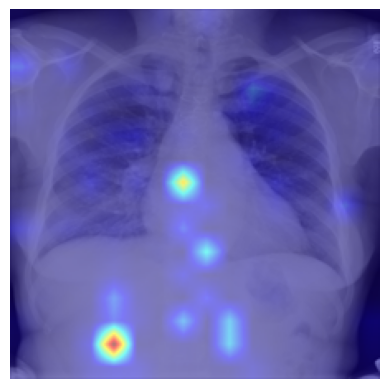

In [7]:
#IU_XRAY report KL
# question = "Does the image show any signs of liver cancer?"
# question = "Does the image show any signs of enlarged heart?"
# question = "What is the abnormity on the liver in this image?"
# question = "What is the abnormity on the lungs in this image?"
# question = "What modality is used to take this image?"
# question = "Does the picture contain liver?"
# question = "Does the picture contain spleen?"
question = "Analyze the chest X-ray and generate a concise medical report."
# question = "Describe this image in details."
image_path = "../images/example2.jpg"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model, question=question, image_path=image_path)
print(text)
img_token_idx = int(torch.where(input_ids[0] == 32001)[0][0])
img_token_idx
len_out_tokens = len(outputs['attentions'])
for i in range(-len_out_tokens + 2, -len_out_tokens + 6):
    attn_all_layers = outputs['attentions'][i]
    token = tokenizer.decode(outputs["sequences"][0][i])
    print(token, "token")
    attn_all_layers_tensor = torch.cat(attn_all_layers, 0).mean(0)
    image_attns = attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+256]
    image_attn_sum = torch.sum(image_attns)
    # attn_before_image = attn_all_layers_tensor[:, :, :img_token_idx]
    # attn_after_image = attn_all_layers_tensor[:, :, img_token_idx+256:]
    attn_before_image = attn_all_layers_tensor[:, :, 2:img_token_idx]
    attn_after_image = attn_all_layers_tensor[:, :, img_token_idx+256:-2]
    text_attn_sum = torch.sum(attn_before_image)
    text_attn_sum2 = torch.sum(attn_after_image)
    print(image_attns.size(), image_attn_sum, attn_before_image.size(), attn_after_image.size(),  text_attn_sum, text_attn_sum2)
    # fig = show_image_relevance(attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+256].mean(axis=0).mean(axis=0), image, orig_image=image, mask=None, preprocess=preprocess, only_map=True, show_mask=False)

img_token_idx
img_token_idx = int(torch.where(input_ids[0] == 32001)[0][0])
print(img_token_idx)
for i in range(-8, -6):
    attn_all_layers = outputs['attentions'][i]
    token = tokenizer.decode(outputs["sequences"][0][i])
    print(token)
    attn_all_layers_tensor = torch.cat(attn_all_layers, 0).mean(0)
    fig = show_image_relevance(attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+256].mean(axis=0).mean(axis=0), image, orig_image=image, mask=None, preprocess=preprocess, only_map=True, show_mask=False)

In [8]:
# question = "Does the image show any signs of liver cancer?"
# question = "Does the image show any signs of enlarged heart?"
# question = "What is the abnormity on the liver in this image?"
# question = "What is the abnormity on the lungs in this image?"
# question = "What modality is used to take this image?"
# question = "Does the picture contain liver?"
question = "Does the picture contain spleen?"
# question = "Describe this image in details."
image_path = "../images/example1.jpg"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model, question=question, image_path=image_path)
print(text)
img_token_idx = int(torch.where(input_ids[0] == 32001)[0][0])
img_token_idx
len_out_tokens = len(outputs['attentions'])
for i in range(-len_out_tokens + 2, -len_out_tokens + 6):
    attn_all_layers = outputs['attentions'][i]
    token = tokenizer.decode(outputs["sequences"][0][i])
    print(token, "token")
    attn_all_layers_tensor = torch.cat(attn_all_layers, 0).mean(0)
    image_attns = attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+256]
    image_attn_sum = torch.sum(image_attns)
    # attn_before_image = attn_all_layers_tensor[:, :, :img_token_idx]
    # attn_after_image = attn_all_layers_tensor[:, :, img_token_idx+256:]
    attn_before_image = attn_all_layers_tensor[:, :, 2:img_token_idx]
    attn_after_image = attn_all_layers_tensor[:, :, img_token_idx+256:-2]
    text_attn_sum = torch.sum(attn_before_image)
    text_attn_sum2 = torch.sum(attn_after_image)
    print(image_attns.size(), image_attn_sum, attn_before_image.size(), attn_after_image.size(),  text_attn_sum, text_attn_sum2)
    # fig = show_image_relevance(attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+256].mean(axis=0).mean(axis=0), image, orig_image=image, mask=None, preprocess=preprocess, only_map=True, show_mask=False)


/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/generation/utils.py:1542: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


 Assistant: Yes

</s> A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions.###Human: <im_start><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><im_patch><i

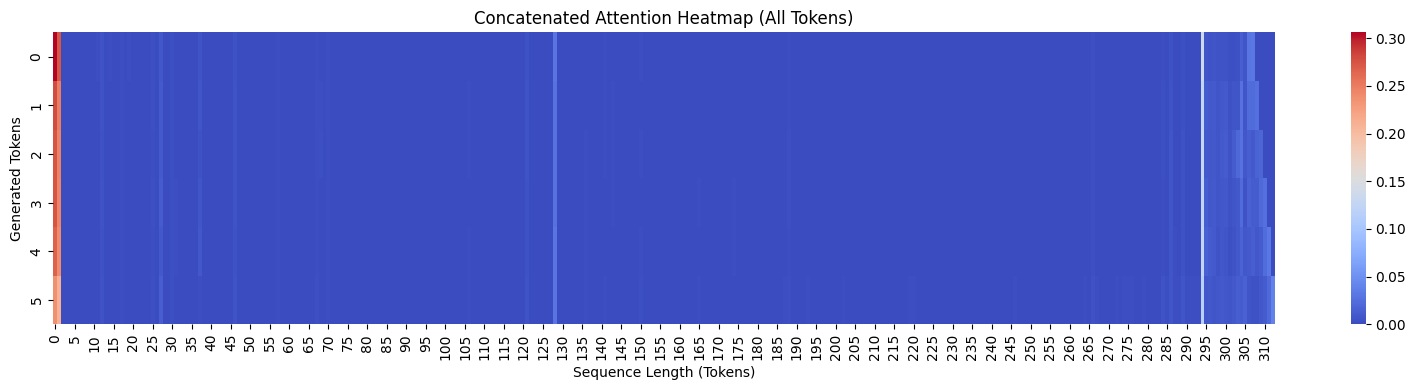

In [9]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def pad_and_concat_attentions(attention_tuple, max_seq_len):
    """
    Pad attention maps with zeros and concatenate them.
    
    Args:
    - attention_tuple: Tuple of attention tensors, where each tensor corresponds to one generated token's attention.
                       Shape: (generated_token_length, layers, 1, heads, 1, seq_len)
    - max_seq_len: The maximum sequence length to pad to.
    
    Returns:
    - concatenated_attentions: Tensor of concatenated attention maps (generated_token_length, seq_len)
    """
    padded_attentions = []
    
    for attn_tensor in attention_tuple:
        # print(attn_tensor.size())
        seq_len = attn_tensor[0].shape[-1]  # Current sequence length for this token
        padding_len = max_seq_len - seq_len
        
        attn_tensor = torch.cat(attn_tensor, 0).mean(0)
        # print(attn_tensor.size())
        # Average over layers and heads
        attn_tensor_avg = attn_tensor.mean(0).squeeze().squeeze().cpu() # Shape: (seq_len,)
        
        # Pad attention tensor with zeros to match max_seq_len
        if padding_len > 0:
            attn_tensor_avg = torch.cat([attn_tensor_avg, torch.zeros(padding_len)], dim=-1)
        
        padded_attentions.append(attn_tensor_avg)
    
    # Concatenate attentions across generated tokens
    concatenated_attentions = torch.stack(padded_attentions, dim=0)
    
    return concatenated_attentions

def draw_concatenated_attention_heatmap(concatenated_attentions):
    """
    Draw a heatmap of concatenated attention scores.
    
    Args:
    - concatenated_attentions: Tensor of concatenated attention scores (generated_token_length, seq_len).
    """
    
    plt.figure(figsize=(16, 4))
    
    # Convert tensor to numpy for plotting
    attention_data = concatenated_attentions.cpu().detach().numpy()
    
    sns.heatmap(attention_data, cmap='coolwarm', cbar=True)
    
    plt.title("Concatenated Attention Heatmap (All Tokens)")
    plt.xlabel("Sequence Length (Tokens)")
    plt.ylabel("Generated Tokens")
    plt.tight_layout()
    plt.show()

# Assume that the output attentions are of the shape (generated_token_length, layers, 1, heads, 1, seq_len)
generated_token_length = len(outputs['attentions'])
max_seq_len = max([attn[0].shape[-1] for attn in outputs['attentions']])  # Max sequence length over all generated tokens

# Pad and concatenate attentions
concatenated_attentions = pad_and_concat_attentions(outputs['attentions'][1:], max_seq_len)

# Draw heatmap
draw_concatenated_attention_heatmap(concatenated_attentions)


38
istant
:
Yes


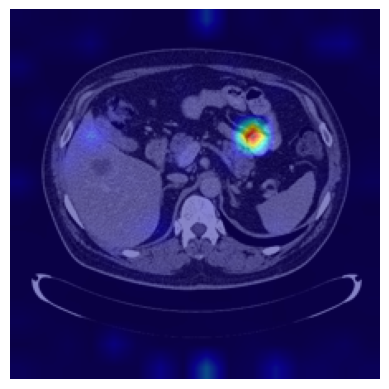

In [10]:
img_token_idx
img_token_idx = int(torch.where(input_ids[0] == 32001)[0][0])
print(img_token_idx)
for i in range(-6, -3):
    attn_all_layers = outputs['attentions'][i]
    token = tokenizer.decode(outputs["sequences"][0][i])
    print(token)
    attn_all_layers_tensor = torch.cat(attn_all_layers, 0).mean(0)
    fig = show_image_relevance(attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+256].mean(axis=0).mean(axis=0), image, orig_image=image, mask=None, preprocess=preprocess, only_map=True, show_mask=False)

38
istant
:
Yes


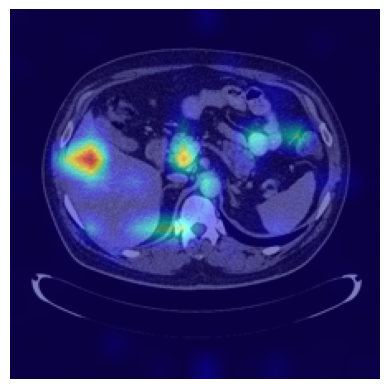

In [20]:
img_token_idx
img_token_idx = int(torch.where(input_ids[0] == 32001)[0][0])
print(img_token_idx)
for i in range(-6, -3):
    attn_all_layers = outputs['attentions'][i]
    token = tokenizer.decode(outputs["sequences"][0][i])
    print(token)
    attn_all_layers_tensor = torch.cat(attn_all_layers, 0).mean(0)
    fig = show_image_relevance(attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+256].mean(axis=0).mean(axis=0), image, orig_image=image, mask=None, preprocess=preprocess, only_map=True, show_mask=False)

In [9]:
# for (n,p) in model.named_parameters():
#     if p.requires_grad:
#         print(n)